In [32]:
%run './model/multi_corpus.py'
%run './constants.py'

sns.set(rc = {'figure.figsize':(15,8)})

In [33]:
cog = co_occurence_graphs(n_edges=50)

Gender Studies Graph with 33 nodes and 50 edges
Geometry Graph with 36 nodes and 50 edges
Geophysics Graph with 39 nodes and 50 edges
Economics Graph with 31 nodes and 50 edges
Language & Linguistics Graph with 33 nodes and 50 edges
Probability & Statistics Graph with 33 nodes and 50 edges
Material Engineering Graph with 31 nodes and 50 edges
Artificial Intelligence Graph with 28 nodes and 50 edges
Sociology Graph with 46 nodes and 50 edges
International Business Graph with 30 nodes and 50 edges
Political Science Graph with 37 nodes and 50 edges
Genetics & Genomics Graph with 37 nodes and 50 edges
Immunology Graph with 50 nodes and 50 edges
Human Resources & Organizations Graph with 45 nodes and 50 edges
Ethnic & Cultural Studies Graph with 37 nodes and 50 edges
Neurology Graph with 30 nodes and 50 edges


In [34]:
ccg = co_citation_graphs(n_edges=50)

Gender Studies Graph with 43 nodes and 50 edges
Geometry Graph with 37 nodes and 50 edges
Geophysics Graph with 65 nodes and 50 edges
Economics Graph with 43 nodes and 50 edges
Language & Linguistics Graph with 44 nodes and 50 edges
Probability & Statistics Graph with 26 nodes and 50 edges
Material Engineering Graph with 58 nodes and 50 edges
Artificial Intelligence Graph with 48 nodes and 50 edges
Sociology Graph with 39 nodes and 50 edges
International Business Graph with 34 nodes and 50 edges
Political Science Graph with 69 nodes and 50 edges
Genetics & Genomics Graph with 14 nodes and 50 edges
Immunology Graph with 62 nodes and 50 edges
Human Resources & Organizations Graph with 54 nodes and 50 edges
Ethnic & Cultural Studies Graph with 64 nodes and 50 edges
Neurology Graph with 33 nodes and 50 edges


In [51]:
field_name = 'Sociology'

df = pl.read_parquet(os.path.join(CITATION_DF_PATH, field_name + '.parquet'))

Gcc = ccg[field_name]['G']
Gco = cog[field_name]['G']

G = nx.compose(Gcc, Gco)

assert(len(Gcc.nodes) + len(Gco.nodes) == len(G.nodes))
assert(len(Gcc.edges) + len(Gco.edges) == len(G.edges))

print(G)

Graph with 85 nodes and 100 edges


In [58]:
dois = list(Gcc.nodes)
terms = list(Gco.nodes)

edges = (
    df
    .filter(pl.col('Doi').is_in(dois))
    .select(
        pl.col('Doi'),
        # pl.col('AuthorsDisplay'),
        pl.col('Text').arr.eval(pl.element().filter(pl.element().is_in(terms)))
    )
    .explode(pl.col('Text'))
    .to_numpy()
)

for (u, v) in edges:
    if u in G and v in G:
        G.add_edge(u, v)

print(G)

Graph with 85 nodes and 407 edges


In [92]:
size_fact = 10000
size_min = 200

bc = nx.betweenness_centrality(G)

dois_bcs = {doi: bc[doi] for doi in dois}
dois, dois_bcs = zip(*dois_bcs.items())
dois_bc = np.fromiter(dois_bcs, float)
dois_bc = dois_bc / dois_bc.max() * size_fact
dois_bc = np.maximum(dois_bc, size_min)

terms_bcs = {term: bc[term] for term in terms}
terms, terms_bcs = zip(*terms_bcs.items())
terms_bc = np.fromiter(terms_bcs, float)
terms_bc = terms_bc / terms_bc.max() * size_fact
terms_bc = np.maximum(terms_bc, size_min)

dois_bcs = dict(zip(dois, dois_bc))
terms_bcs = dict(zip(terms, terms_bc))

nodes = dict()
nodes.update(dois_bcs)
nodes.update(terms_bcs)

all_nodes = list(nodes.keys())
all_bcs = list(nodes.values())

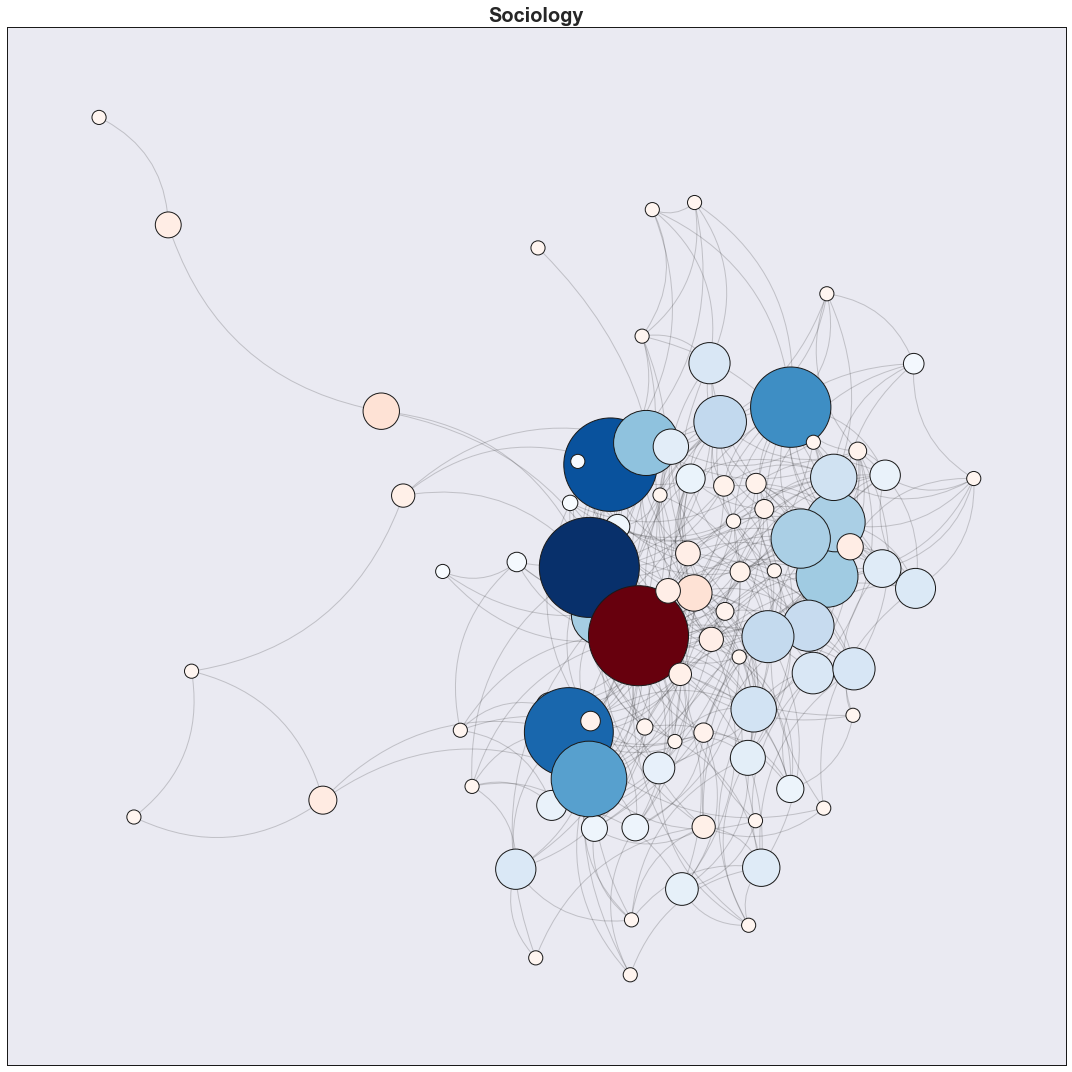

In [93]:

fig, ax = plt.subplots(1, figsize=(15, 15))

pos = nx.nx_agraph.graphviz_layout(G, prog='sfdp') # dot, twopi, fdp, sfdp, circo

nx.draw_networkx_nodes(
    G, 
    pos,
    nodelist=dois,
    node_size=dois_bc,
    node_color=dois_bc,
    node_shape='o',
    alpha=None,
    cmap=plt.cm.Blues,
    ax=ax,
    linewidths=1.0,
    edgecolors='k',
).set_zorder(1)

nx.draw_networkx_nodes(
    G, 
    pos,
    nodelist=terms,
    node_size=terms_bc,
    node_color=terms_bc,
    node_shape='o',
    alpha=None,
    cmap=plt.cm.Reds,
    ax=ax,
    linewidths=1.0,
    edgecolors='k',
).set_zorder(1)

# nx.draw_networkx_labels(G, pos=pos, ax=ax, labels=node_labels)

edges = nx.draw_networkx_edges(
    G, 
    pos,
    width=1.0,
    edge_color='k',
    style='solid',
    alpha=0.2,
    arrowsize=10,
    ax=ax,
    nodelist=all_nodes,
    node_size=all_bcs,
    node_shape='o',
    arrows=True,
    connectionstyle='arc3, rad=0.3',
)

for c in edges:
    c.set_zorder(-1)

ax.set_title(f'{field_name.capitalize()}', fontweight='semibold', fontsize=20)

ax.spines['top'].set_color('k')
ax.spines['top'].set_linewidth(1)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(1)
ax.spines['right'].set_color('k')
ax.spines['right'].set_linewidth(1)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(1)

ax.grid(False)

plt.tight_layout()
# plt.savefig(f'{OBSIDIAN_IMG_PATH}/co_occurence_networks.png')
plt.show()

In [94]:
os.listdir('./output/co_occurence_graphs/')

['Political Science.edgelist',
 'Ethnic & Cultural Studies.edgelist',
 'Geophysics.edgelist',
 'Gender Studies.edgelist',
 'International Business.edgelist',
 'Human Resources & Organizations.edgelist',
 'Language & Linguistics.edgelist',
 'Neurology.edgelist',
 'Economics.edgelist',
 'Artificial Intelligence.edgelist',
 'Genetics & Genomics.edgelist',
 'Probability & Statistics.edgelist',
 'Sociology.edgelist',
 'Material Engineering.edgelist',
 'Immunology.edgelist',
 'Geometry.edgelist']